In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [64]:
class PreProcessing():
    def __init__(self, df : pd.DataFrame = pd.DataFrame) :
        self.df = df
        
    
    def Information (self , df) :
        self.df = df
        df.replace('?' , np.nan , inplace = True )
        nulls = (df.shape[0] - df.dropna(axis = 0).shape[0])
        nulls_per = (df.shape[0] - df.dropna(axis = 0).shape[0]) / df.shape[0]
        dup , dup_per = df.duplicated().sum() , (df.duplicated().sum()) / df.shape[0]
        numerical_columns = list((df.select_dtypes(include=np.number)).columns)
        categorical_columns = list(df.select_dtypes(include = ['object']).columns)
        numerical_col_dict = {}
        for col in numerical_columns :
            if df[col].nunique() > 10 :
                numerical_col_dict[col] = 'Continuous' 

            else :
                numerical_col_dict[col] = 'Discrete'
        categorical_col_dict = {}
        for col in categorical_columns :
            if df[col].nunique() > 10 :
                categorical_col_dict[col] = 'Continuous' 

            else :
                categorical_col_dict[col] = 'Classes'
        x = []
        for col in df.columns : 
            x.append([col , df[col].unique() ,df[col].nunique(),df[col].dtype,df[col].isna().sum(),int((df[col].isna().sum())/df.shape[0] * 100)  ])

        x = pd.DataFrame(x ,columns=['Feature','Unique_Values','No.OfUniqueValues','DataType','NoOfNulls','Nulls %'])
        
        print('\n','There is : {}  Nulls, Representing {} % of The Data'.format(nulls , '%.2f'%nulls_per ))
        print('\n','There is : {}  Duplicated, Representing {} % of The Data'.format(dup , '%.2f'%dup_per))
        print('\n','Numerical Columns : {}'.format(numerical_col_dict))
        print('\n','Categorical Columns : {}'.format(categorical_col_dict))
        
        return x
    
    def ImputeNulls(self , df , col_method : dict = {} ,col_value = {} ,type_method : dict = {} ) :
        self.df = df
        self.col_method = col_method
        self.type_method = type_method
        self.col_value = col_value
        df_copy = df.copy(deep = True)
        if len(col_method) == 0 & len(type_method) == 0  : 
            numerical_columns = list((df_copy.select_dtypes(include=np.number)).columns)
            categorical_columns = list(df_copy.select_dtypes(include = ['object']).columns)

            for col in numerical_columns :
                df_copy[col] = df_copy[col].interpolate()
                
            df_copy[categorical_columns] = df_copy[categorical_columns].apply(lambda x:x.fillna(x.value_counts().index[0]))
    
                
        if len(col_method) != 0 :
            for col in col_method.keys() :
                df_copy[col] = df_copy[col].fillna(method = col_method[col])
        
        if len(col_value) != 0 :
            for col in col_value.keys() :
                df_copy[col] = df_copy[col].fillna(value = col_value[col])
        
        if len(type_method) != 0 :
            numerical_columns = list((df_copy.select_dtypes(include=np.number)).columns)
            categorical_columns = list(df_copy.select_dtypes(include = ['object']).columns)
            for col in numerical_columns :
                df_copy[col] = df_copy[col].fillna(method = type_method['int'])
                
            for col in categorical_columns :
                df_copy[col] = df_copy[col].fillna(method = type_method['object'])
                
        return df_copy
    
    
    def Oultiers(self , df , display = False , drop = False , drop_order = 1 ,columns_to_display = [], columns_to_drop = []) :
        self.df = df
        self.display = display
        self.drop = drop
        self.drop_order = drop_order
        self.columns_to_display = columns_to_display
        self.columns_to_drop = columns_to_drop
        df_copy = df.copy(deep = True)
        numerical_columns = list((df_copy.select_dtypes(include=np.number)).columns)


        if display == True :
            if (len(columns_to_display) != 0) :
                numerical_columns = columns_to_display
            from math import ceil
            x = ceil(len(numerical_columns)/2)
            if len(numerical_columns) >= 24 :
                fig = plt.figure(figsize=(128,96))
            else : 
                fig = plt.figure(figsize=(24, 12))

            sns.set_theme(style="whitegrid", palette="pastel")
            plt.subplots_adjust(hspace=0.5)
            subfigs = fig.subfigures(len(numerical_columns), 1)
            for idx , i in enumerate(numerical_columns) :
                (ax1, ax2) = subfigs[idx].subplots(1, 2)
                sns.boxplot(x = df_copy[i] ,data = df_copy , ax = ax1 )
                sns.histplot(x = df_copy[i], kde=True , ax = ax2 )
                subfigs[idx].subplots_adjust(bottom=0.5, right=0.8, top=0.75)
                ax1.set_title(i)
                ax2.set_title(i)

        if drop == True :
            if (len(columns_to_drop) != 0) :
                numerical_columns = columns_to_drop
            elif drop_order < 1 :
                drop_order = 1

            import scipy.stats as stats

            while drop_order != 0 :
                for col in  numerical_columns :
                    p_value = stats.normaltest(df_copy[col])
                    if p_value[1] >= .05 :                                      ## col is normally distributed
                        filt = (df_copy[col]-df_copy[col].mean())/df_copy[col].std()
                        indexes = (filt[filt > 3]).index
                        df_copy.drop(indexes , inplace = True )
                        df_copy.reset_index(drop=True , inplace=True)

                    else :                                                     ## col is Skewed 

                        q1 = df_copy[col].quantile(0.25)
                        q3 = df_copy[col].quantile(0.75)
                        iqr = q3 - q1
                        lower = q1 - 1.5*iqr
                        if lower < 0 :
                            lower = 0
                        higher = q3 + 1.5*iqr
                        df_copy = df_copy [df_copy[col] >= lower] 
                        df_copy = df_copy [df_copy[col] <= higher ]
                        df_copy.reset_index(drop=True , inplace=True)

                drop_order = drop_order - 1
                
        return df_copy

       
        
    def Encode_Categorical(self , df , col_method={} ,one_hot = False , labeling = False ,defult = False ) :
        self.df = df 
        self.one_hot = one_hot
        self.labeling = labeling
        self.col_method = col_method
        df_copy = df.copy(deep = True)
        from sklearn import preprocessing
        
        if len(col_method) != 0 :
            label_cols = []
            one_hot_cols = []
            
            for col in col_method.keys() :
                if 'label' in col_method[col] :
                    label_cols.append(col)
                else :
                    one_hot_cols.append(col)
            if len(label_cols) !=0 :
                label_encoder = preprocessing.LabelEncoder()
                for col in label_cols :
                    df_copy[col]= label_encoder.fit_transform(df_copy[col])
            if len(one_hot_cols) !=0 :
                dummies = pd.get_dummies(one_hot_cols , drop_first=True)
                df_copy.drop(one_hot_cols,axis=1,inplace=True)
                df_copy = df_copy.join(dummies)

        
        elif defult == True :
            categorical_columns = list(df_copy.select_dtypes(include = ['object']).columns)
            one_hot_encoding = []
            label_encoder = preprocessing.LabelEncoder()
            for col in categorical_columns :
                if df_copy[col].nunique() < 20 :
                    one_hot_encoding.append(col)
                    
                else :
                    df_copy[col]= label_encoder.fit_transform(df_copy[col])
                    
            df_copy = pd.get_dummies(df_copy , drop_first=True)
                    
                
                    
        
        elif one_hot == True :
            df_copy = pd.get_dummies(df_copy , drop_first=True)
            
        elif labeling == True :
            from sklearn import preprocessing
            label_encoder = preprocessing.LabelEncoder()
            for col in df_copy.columns :
                df_copy[col]= label_encoder.fit_transform(df_copy[col])
                
                
        return df_copy
    
    
    def Model (self , df , model ,target_name , problem ,test_size = 0.3 , random_state = 42 ) :
        self.df = df
        self.model = model
        self.target_name = target_name
        self.problem = problem
        self.test_size = test_size
        self.random_state = random_state
        
        
        from sklearn.model_selection import train_test_split
        from sklearn.metrics import accuracy_score ,recall_score,precision_score,f1_score ,classification_report , r2_score
        x = df.drop([target_name] , axis = 1)
        y = df[target_name]
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = test_size, random_state = random_state)
        
        list_of_models = [model]
        if problem == 'Classification' :
            classification_report = pd.DataFrame(columns=['Accuracy','F1_score','Precision','Recall'])
            for model in list_of_models :
                model = model
                model.fit(x_train , y_train)
                for i in range(2) :

                    if i == 0 :
                        to_pred = x_train
                        pred = y_train
                        title = 'Train'

                    else :
                        to_pred = x_test
                        pred = y_test
                        title = 'Test'
                    y_pred = model.predict(to_pred)
                    acc = round(accuracy_score(pred , y_pred)*100)
                    f1 = round(f1_score(pred , y_pred)*100)
                    prec = round(precision_score(pred , y_pred)*100)
                    recall = round(recall_score(pred , y_pred)*100)
                    d = pd.DataFrame(data=np.array([acc,f1,prec,recall]).reshape(1,4) 
                                 , columns=['Accuracy' , 'F1_score' , 'Precision' , 'Recall'])  
                    classification_report = pd.concat([classification_report , d])
                    classification_report.rename( index= { 0 :'{} _ {} Details'.format(model , title) } ,inplace=True )
                    
        elif problem == 'Regression' :
            classification_report = pd.DataFrame(columns=['Score'])
            for model in list_of_models :
                model = model
                model.fit(x_train , y_train)
                for i in range(2) :

                    if i == 0 :
                        to_pred = x_train
                        pred = y_train
                        title = 'Train'

                    else :
                        to_pred = x_test
                        pred = y_test
                        title = 'Test'
                    y_pred = model.predict(to_pred)
                    acc = round(r2_score(pred , y_pred)*100)
                    d = pd.DataFrame(data=np.array([acc]).reshape(1,1) 
                                 , columns=['Score'])  
                    classification_report = pd.concat([classification_report , d])
                    classification_report.rename( index= { 0 :'{} _ {} Details'.format(model , title) } ,inplace=True )
                    
        print(classification_report)
        return model


In [65]:
df = pd.read_csv('titanic-data.csv')
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [66]:
pre = PreProcessing()

# Information

In [67]:
pre.Information(df)


 There is : 708  Nulls, Representing 0.79 % of The Data

 There is : 0  Duplicated, Representing 0.00 % of The Data

 Numerical Columns : {'PassengerId': 'Continuous', 'Survived': 'Discrete', 'Pclass': 'Discrete', 'Age': 'Continuous', 'SibSp': 'Discrete', 'Parch': 'Discrete', 'Fare': 'Continuous'}

 Categorical Columns : {'Name': 'Continuous', 'Sex': 'Classes', 'Ticket': 'Continuous', 'Cabin': 'Continuous', 'Embarked': 'Classes'}


,Feature,Unique_Values,No.OfUniqueValues,DataType,NoOfNulls,Nulls %
0,PassengerId,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",891,int64,0,0
1,Survived,"[0, 1]",2,int64,0,0
2,Pclass,"[3, 1, 2]",3,int64,0,0
3,Name,"[Braund, Mr. Owen Harris, Cumings, Mrs. John B...",891,object,0,0
4,Sex,"[male, female]",2,object,0,0
5,Age,"[22.0, 38.0, 26.0, 35.0, nan, 54.0, 2.0, 27.0,...",88,float64,177,19
6,SibSp,"[1, 0, 3, 4, 2, 5, 8]",7,int64,0,0
7,Parch,"[0, 1, 2, 5, 3, 4, 6]",7,int64,0,0
8,Ticket,"[A/5 21171, PC 17599, STON/O2. 3101282, 113803...",681,object,0,0
9,Fare,"[7.25, 71.2833, 7.925, 53.1, 8.05, 8.4583, 51....",248,float64,0,0


# Impute Nulls

if you use call_method so it's such a Dictionary , you must write column exact as it's written in data frame which will be the key , and method must be from methods where in pandas.DataFrame.fillna and which will be the value of key

same thing for col_value 

if you will use type_method , your key will be the type "int" or "object" , and the method corresponding to this type

if you uses the defult , numerical will imputing by interpolate , object will imputing by most Frequent

In [68]:
df['Cabin'].value_counts().index[0]

'B96 B98'

In [69]:
df_1 = pre.ImputeNulls(df)
df_2 = pre.ImputeNulls(df , col_value={'Age' : df['Age'].mean() , 'Cabin' : df['Cabin'].value_counts().index[0] ,
                                        'Embarked' : df['Embarked'].value_counts().index[0] })

In [71]:
pre.Information(df_1)


 There is : 0  Nulls, Representing 0.00 % of The Data

 There is : 0  Duplicated, Representing 0.00 % of The Data

 Numerical Columns : {'PassengerId': 'Continuous', 'Survived': 'Discrete', 'Pclass': 'Discrete', 'Age': 'Continuous', 'SibSp': 'Discrete', 'Parch': 'Discrete', 'Fare': 'Continuous'}

 Categorical Columns : {'Name': 'Continuous', 'Sex': 'Classes', 'Ticket': 'Continuous', 'Cabin': 'Continuous', 'Embarked': 'Classes'}


,Feature,Unique_Values,No.OfUniqueValues,DataType,NoOfNulls,Nulls %
0,PassengerId,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",891,int64,0,0
1,Survived,"[0, 1]",2,int64,0,0
2,Pclass,"[3, 1, 2]",3,int64,0,0
3,Name,"[Braund, Mr. Owen Harris, Cumings, Mrs. John B...",891,object,0,0
4,Sex,"[male, female]",2,object,0,0
5,Age,"[22.0, 38.0, 26.0, 35.0, 44.5, 54.0, 2.0, 27.0...",155,float64,0,0
6,SibSp,"[1, 0, 3, 4, 2, 5, 8]",7,int64,0,0
7,Parch,"[0, 1, 2, 5, 3, 4, 6]",7,int64,0,0
8,Ticket,"[A/5 21171, PC 17599, STON/O2. 3101282, 113803...",681,object,0,0
9,Fare,"[7.25, 71.2833, 7.925, 53.1, 8.05, 8.4583, 51....",248,float64,0,0


# Outliers

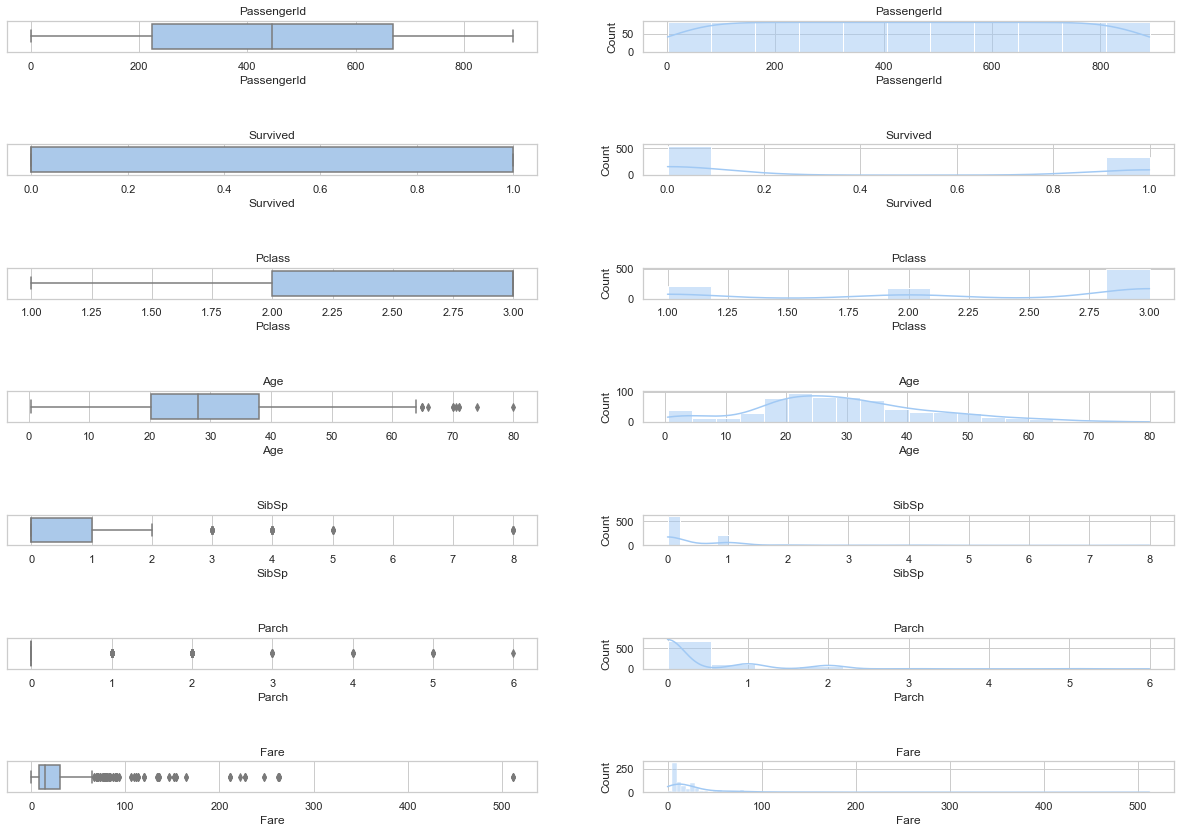

In [70]:
pre.Oultiers(df , display=True)

# Encode Categorical 

if you want to encode all categorical with One hot , make one_hot = True 

if you want to encode all categorical with lebel encodeing , make labeling = True 

if you use defult = True , encoding will be one hot for the columns which the number of unqiue values in it < 20
and label encoding for others columns 

if you want to each specific column certain way , use col_method where it's a Dictionary it's key column and value "label" or "one hot "

In [72]:
df_1 = pre.Encode_Categorical(df_1 , defult=True)
df_2 = pre.Encode_Categorical(df_2 , col_method={'Sex' : 'label' , 'Ticket' : 'label' , 'Cabin' :'label' , 'Embarked':'one_hot'})

In [73]:
df_1.drop(['PassengerId','Name'],axis = 1 , inplace=True)
df_2.drop(['PassengerId','Name'],axis = 1 , inplace=True)

In [75]:
pre.Information(df_2)


 There is : 0  Nulls, Representing 0.00 % of The Data

 There is : 3  Duplicated, Representing 0.00 % of The Data

 Numerical Columns : {'Survived': 'Discrete', 'Pclass': 'Discrete', 'Sex': 'Discrete', 'Age': 'Continuous', 'SibSp': 'Discrete', 'Parch': 'Discrete', 'Ticket': 'Continuous', 'Fare': 'Continuous', 'Cabin': 'Continuous'}

 Categorical Columns : {}


,Feature,Unique_Values,No.OfUniqueValues,DataType,NoOfNulls,Nulls %
0,Survived,"[0, 1]",2,int64,0,0
1,Pclass,"[3, 1, 2]",3,int64,0,0
2,Sex,"[1, 0]",2,int32,0,0
3,Age,"[22.0, 38.0, 26.0, 35.0, 44.5, 54.0, 2.0, 27.0...",155,float64,0,0
4,SibSp,"[1, 0, 3, 4, 2, 5, 8]",7,int64,0,0
5,Parch,"[0, 1, 2, 5, 3, 4, 6]",7,int64,0,0
6,Ticket,"[523, 596, 669, 49, 472, 275, 85, 395, 344, 13...",681,int32,0,0
7,Fare,"[7.25, 71.2833, 7.925, 53.1, 8.05, 8.4583, 51....",248,float64,0,0
8,Cabin,"[47, 81, 55, 129, 145, 49, 111, 13, 63, 41, 10...",147,int32,0,0


# Machine Learning 

you pass the model , test size "defult = 0.3" , target_name ,and problem "regression or classification",  it's perform train_test_split and training ur model 

then return The trained model and Report about training & testing performance 

In [78]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
model1 = pre.Model(df_1 , model=RandomForestClassifier 
                  (max_depth=5 , min_samples_leaf=8,min_samples_split=8 ) ,target_name='Survived' ,problem = 'Classification' ) 

                                                   Accuracy F1_score  \
RandomForestClassifier(max_depth=5, min_samples...       86       79   
RandomForestClassifier(max_depth=5, min_samples...       82       76   

                                                   Precision Recall  
RandomForestClassifier(max_depth=5, min_samples...        91     69  
RandomForestClassifier(max_depth=5, min_samples...        86     68  


In [79]:
model2 = pre.Model(df_2 , model=DecisionTreeClassifier
                  (max_depth=5 , min_samples_leaf=8,min_samples_split=8 ) ,target_name='Survived' ,problem = 'Classification' )

                                                   Accuracy F1_score  \
DecisionTreeClassifier(max_depth=5, min_samples...       86       81   
DecisionTreeClassifier(max_depth=5, min_samples...       81       76   

                                                   Precision Recall  
DecisionTreeClassifier(max_depth=5, min_samples...        81     80  
DecisionTreeClassifier(max_depth=5, min_samples...        78     74  


In [84]:
model1.predict(df_1.drop('Survived' , axis = 1))

array([0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1,
       1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1,